In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm

In [2]:
# Load the dataset
df = pd.read_csv('../manager-course-completion-by-user.csv')

# Filter AP CSP Courses
courses = [
	'Getting Started (AP CSP CodeCombat)',
	'Module 1 (AP CSP CodeCombat) - Course Overview',
	'Module 2 (AP CSP CodeCombat) - Recruitment Strategies',
	'Module 3 (AP CSP CodeCombat) - The Structure of Quests',
	'Module 4 (AP CSP CodeCombat) - Customizing the Course:  Part 1',
	'Module 5 (AP CSP CodeCombat) - Customizing the Course: Part 2',
	'Module 6 (AP CSP CodeCombat) - The Create Task',
	'Module 7 (AP CSP CodeCombat) - The Multiple Choice Exam',
	'Module 8 (AP CSP CodeCombat) - Completing the Course Audit',
#  '(Optional) Module 9 (AP CSP CodeCombat) - Exploring CodeCombat Capstone Projects'
]

df = df[df['Course'].isin(courses)]

# Remove rows with email sonia@codecombat.com
df = df[df['Email'] != 'sonia@codecombat.com']

# Convert 'Time Spent' to minutes for easier analysis
df['Time Spent (min)'] = df['Time Spent (h mm)'].apply(lambda x: int(x.split('h')[0]) * 60 + int(x.split('h')[1].replace('m', '')))

# Handling NaN values - here, we'll drop rows where essential information is missing. Adapt this as necessary.
df.dropna(subset=['Date Completed', 'Time Spent (min)', 'Average Score', 'Progress (Percent)'], inplace=True)

# Descriptive Statistics

## 1. Five Number Summary

In [19]:
# Descriptive statistics for numerical columns
print(df[['Time Spent (min)', 'Average Score', 'Progress (Percent)']].describe())

       Time Spent (min)  Average Score  Progress (Percent)
count        597.000000     597.000000               597.0
mean          40.974874      93.680067               100.0
std           50.456583      10.256107                 0.0
min            1.000000      25.000000               100.0
25%           10.000000      90.000000               100.0
50%           23.000000     100.000000               100.0
75%           53.000000     100.000000               100.0
max          501.000000     100.000000               100.0


## 2. Histogram plot of Average Score per Course

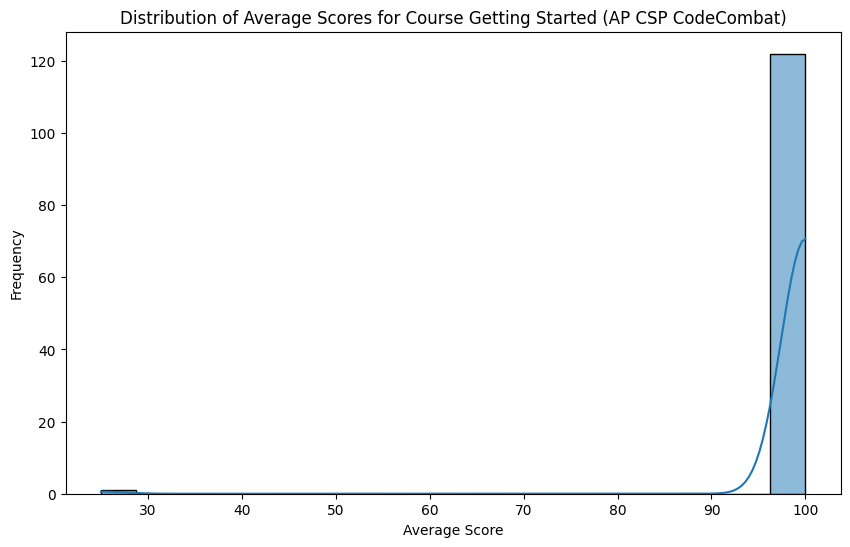

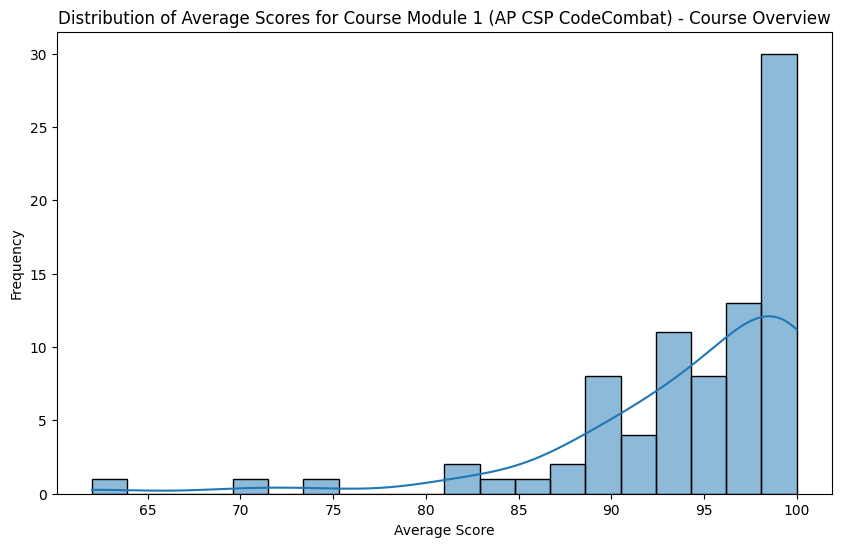

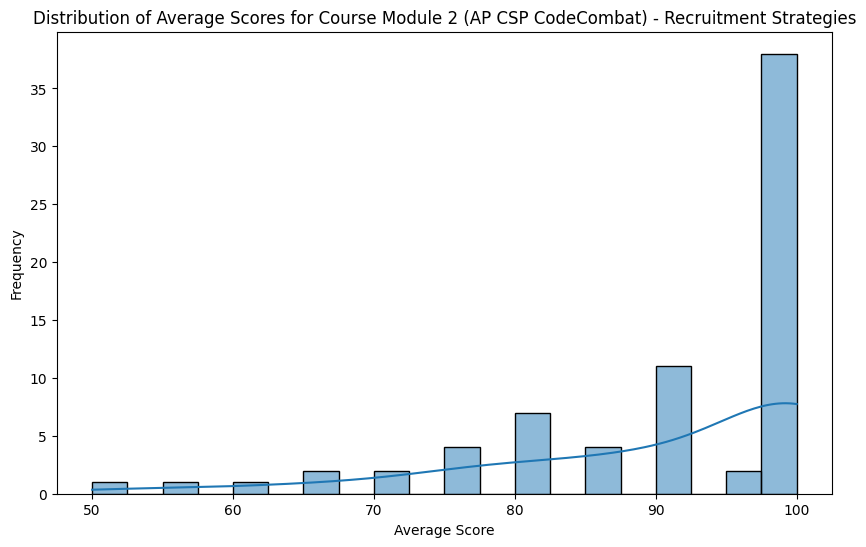

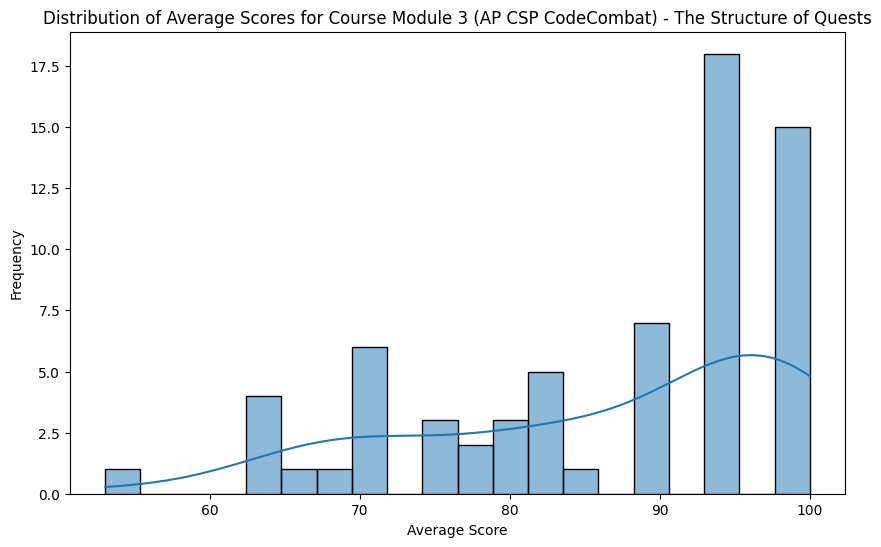

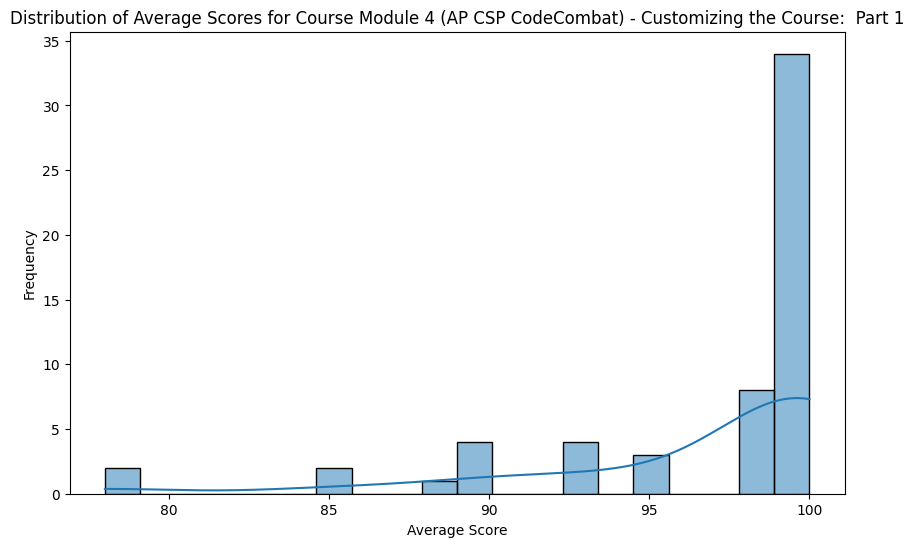

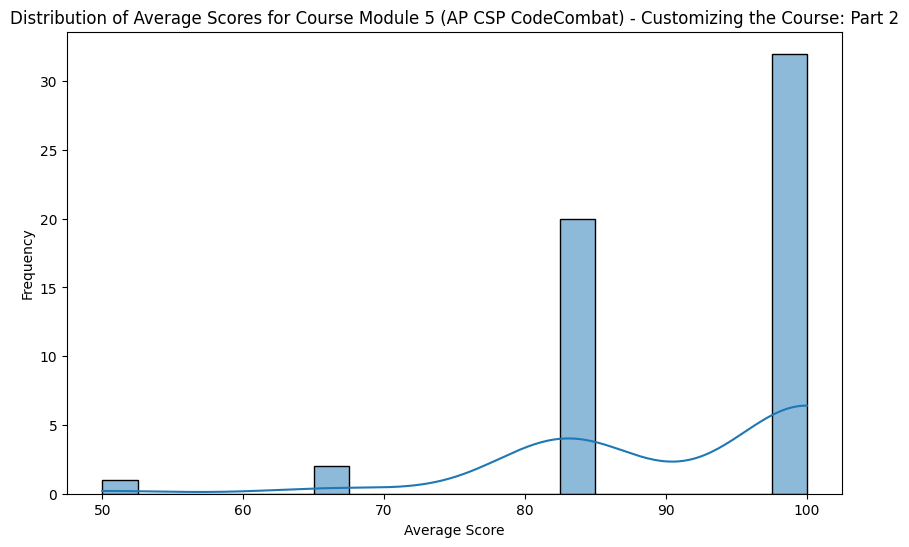

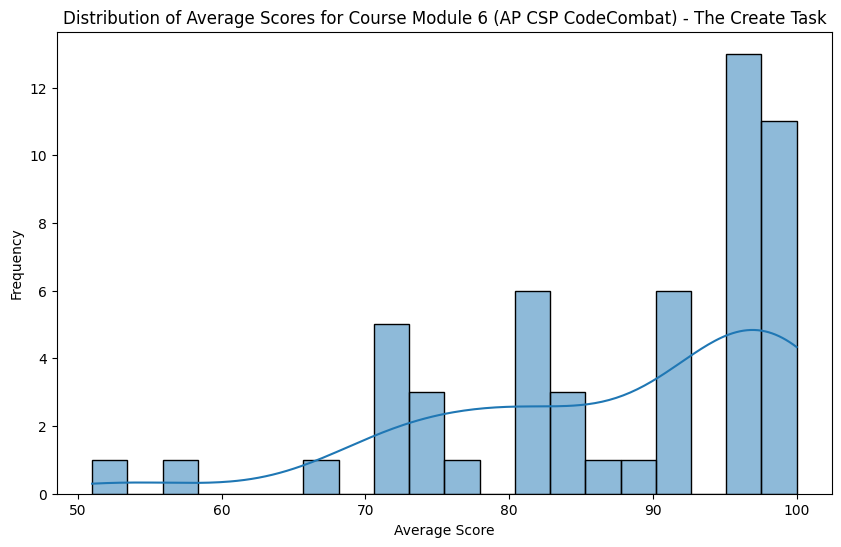

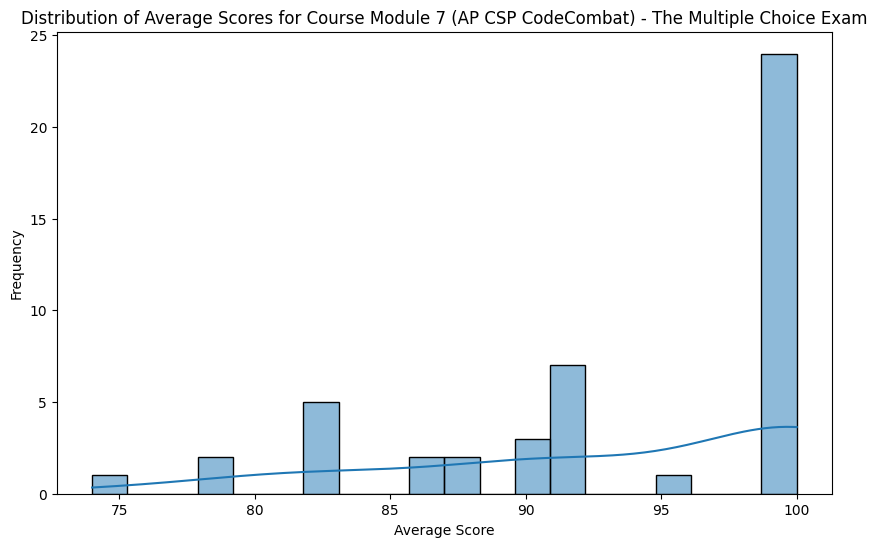

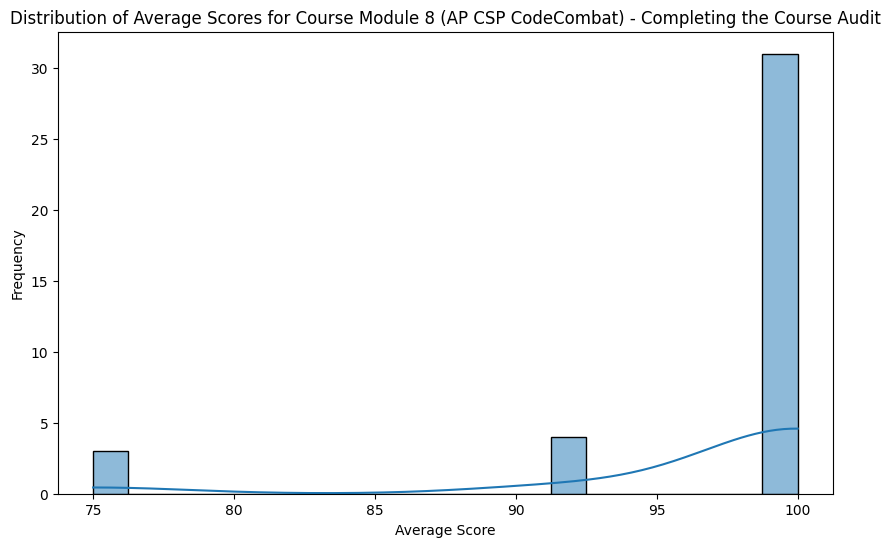

In [6]:
for course, data in grouped:
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Average Score'], kde=True, bins=20)
    plt.title(f'Distribution of Average Scores for Course {course}')
    plt.xlabel('Average Score')
    plt.ylabel('Frequency')
    plt.show()


## 3. Box Plots of Average Scores and Time Spent per Course

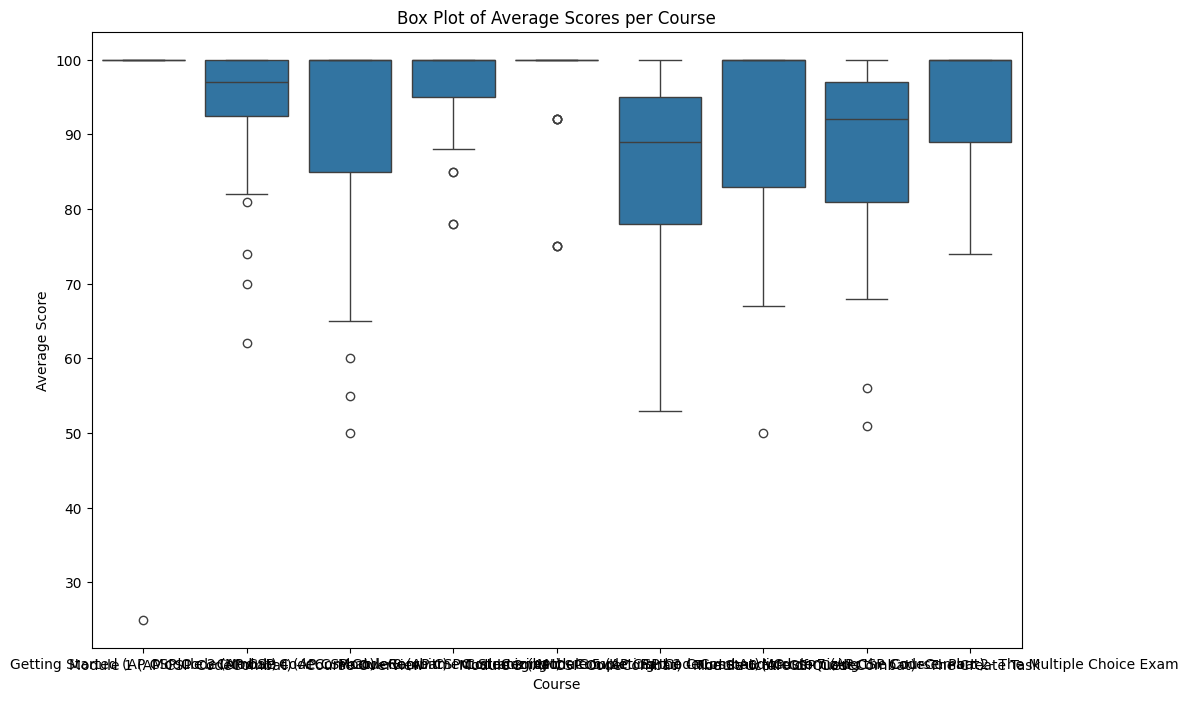

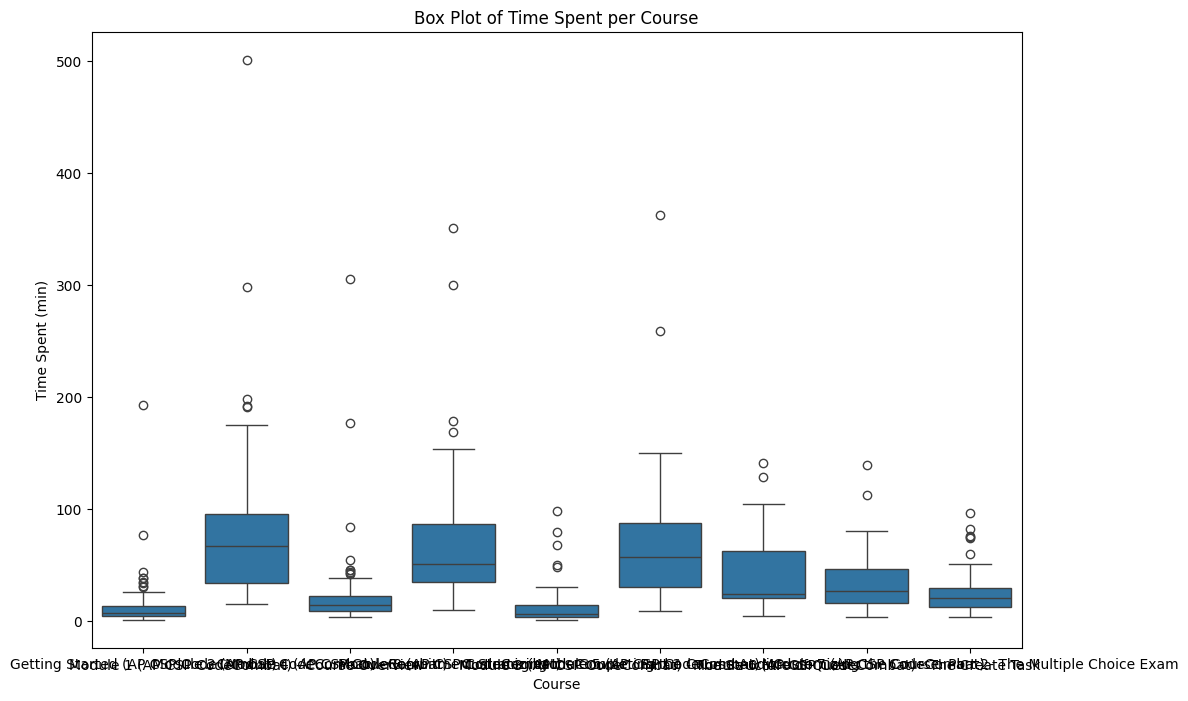

In [7]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Course', y='Average Score', data=df)
plt.title('Box Plot of Average Scores per Course')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='Course', y='Time Spent (min)', data=df)
plt.title('Box Plot of Time Spent per Course')
plt.show()


## 4. Bar Plot of Average Scores per Course

/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_93998/3122827051.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Course', y='Average Score', data=df, ci=None)


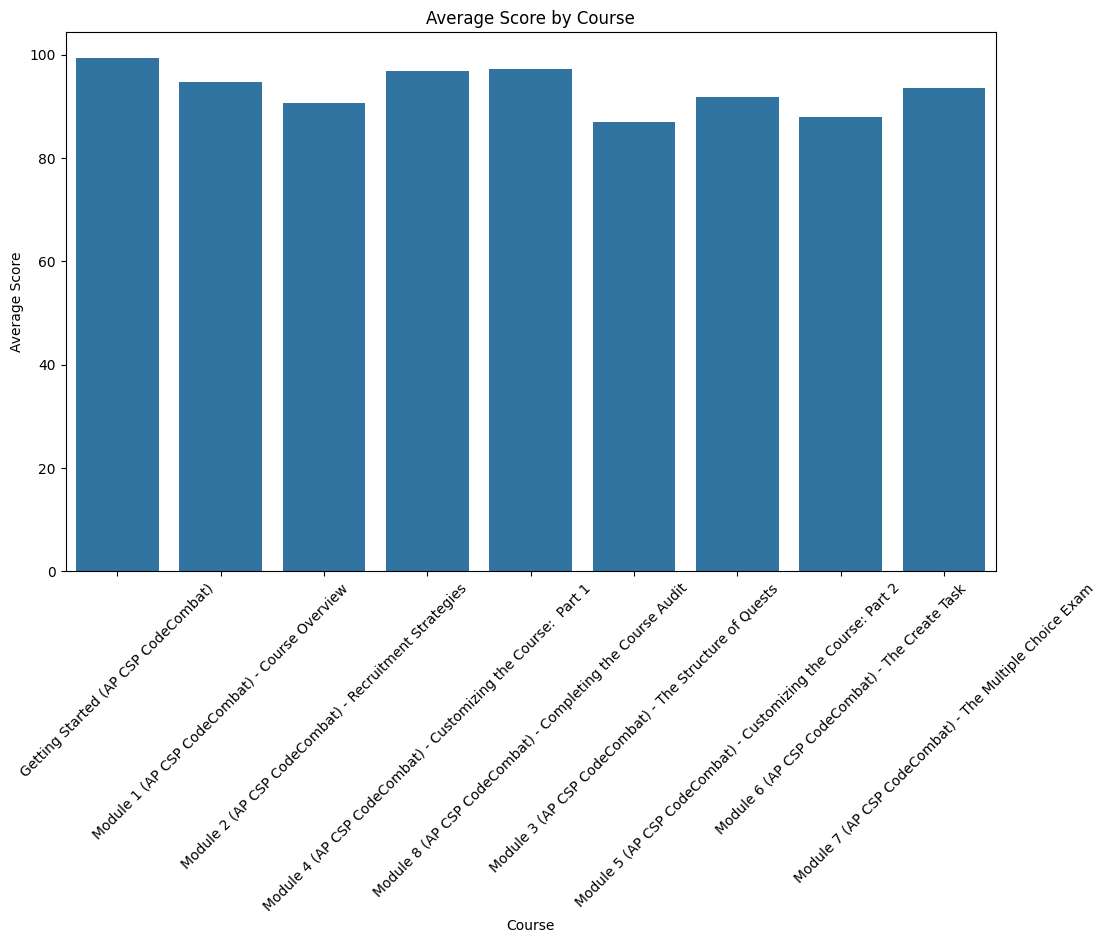

In [8]:
plt.figure(figsize=(12, 7))
sns.barplot(x='Course', y='Average Score', data=df, ci=None)
plt.title('Average Score by Course')
plt.xlabel('Course')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.show()


## 5. Correlation Matrices

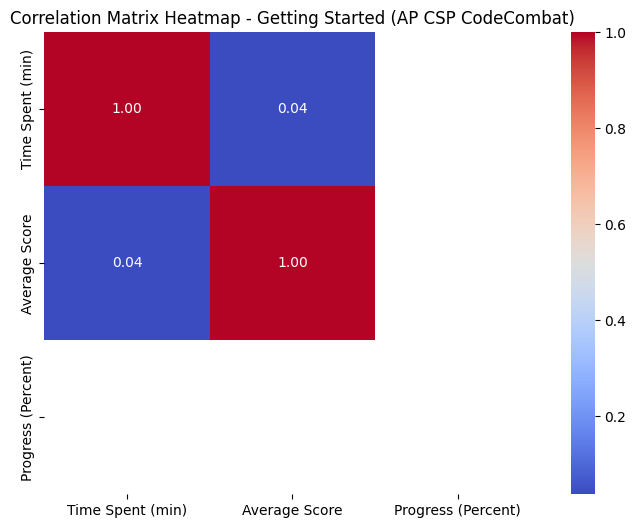

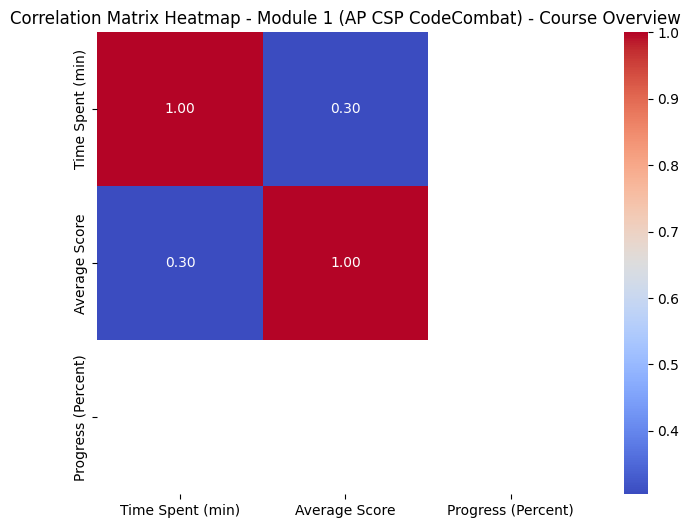

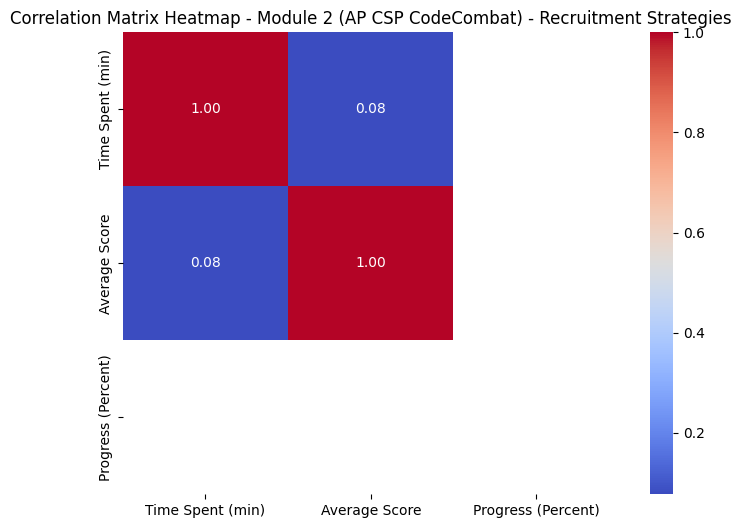

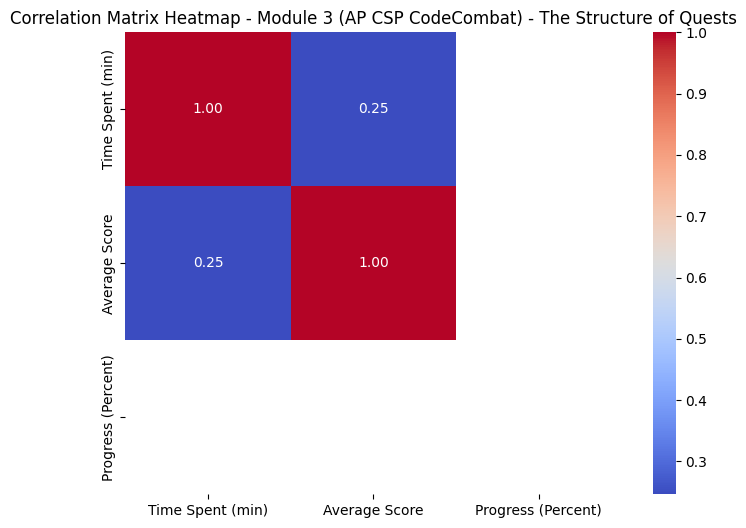

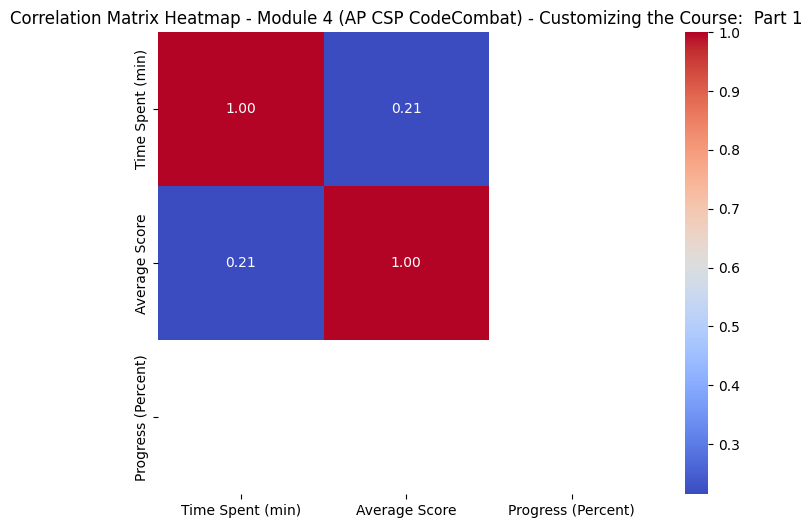

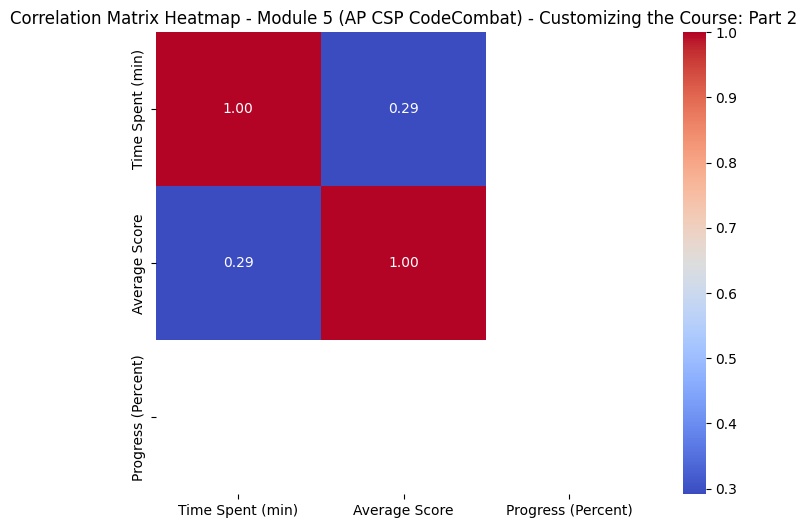

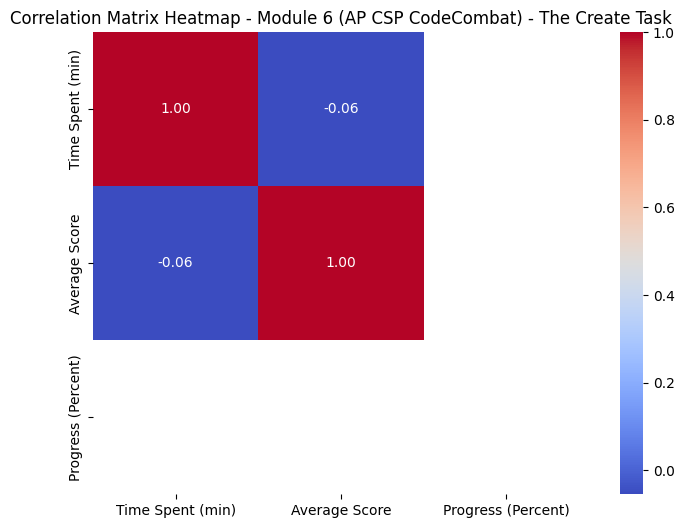

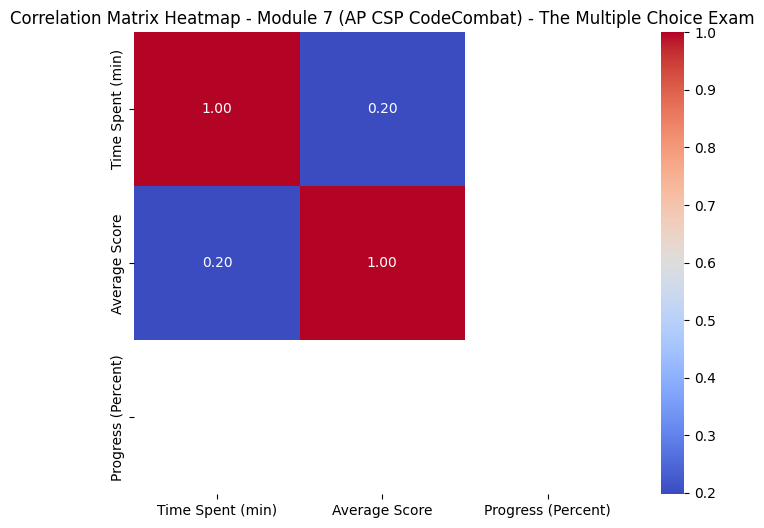

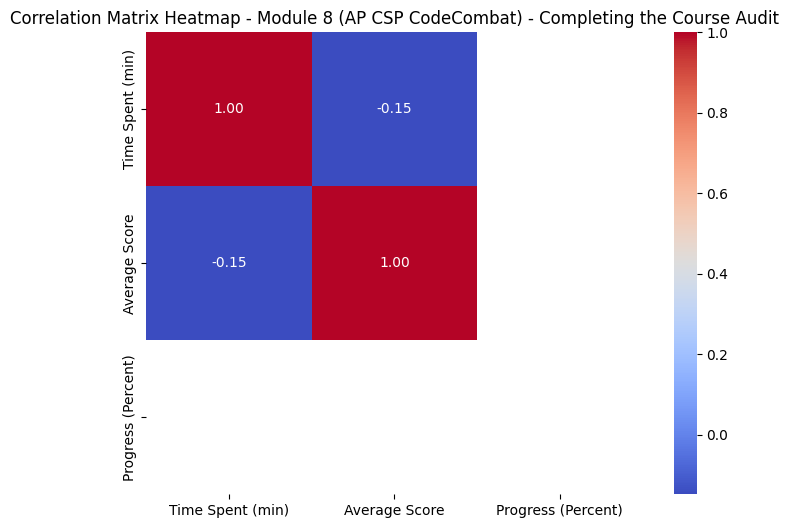

In [9]:
# Calculating the correlation matrix
cols_to_plot = ['Time Spent (min)', 'Average Score', 'Progress (Percent)']

for course, data in grouped:
	corr_matrix = data[cols_to_plot].corr()

	# Plotting the heatmap
	plt.figure(figsize=(8, 6))
	sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
	plt.title('Correlation Matrix Heatmap - ' + course)
	plt.show()


## 6. Z-Score Analyses

In [10]:
def calculate_z_scores(group, column_name):
    # Mean and standard deviation for the column within the group
    mean = group[column_name].mean()
    std = group[column_name].std()
    
    # Calculating Z-score only if std is not 0 to avoid division by zero
    if std > 0:
        group[column_name + ' Z-Score'] = (group[column_name] - mean) / std
    else:
        group[column_name + ' Z-Score'] = 0  # If std is 0, all values are the same and hence their Z-score is 0
    return group

# Ensure 'Course' is not set as index to avoid ambiguity
if 'Course' not in df.columns:
    df.reset_index(inplace=True)

# Apply the Z-score calculation for each course and for the 'Average Score' and 'Time Spent (min)' columns
df = df.groupby('Course', as_index=False).apply(calculate_z_scores, 'Average Score')
df = df.groupby('Course', as_index=False).apply(calculate_z_scores, 'Time Spent (min)')

# After applying, reset the index to flatten the DataFrame and avoid the hierarchical index
df.reset_index(drop=True, inplace=True)


/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_93998/1829855965.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Course', as_index=False).apply(calculate_z_scores, 'Average Score')
/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_93998/1829855965.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Course', as_index=False).apply(calculate_z_scores,

In [24]:
# Identifying outliers based on Z-scores (e.g., Z < -2 or Z > 2)
outliers_avg_score = df[(df['Average Score Z-Score'] < -2) | (df['Average Score Z-Score'] > 2)]
outliers_time_spent = df[(df['Time Spent (min) Z-Score'] < -2) | (df['Time Spent (min) Z-Score'] > 2)]

print("Outliers in Average Score:", outliers_avg_score[['Course', 'User Details', 'Average Score', 'Average Score Z-Score']])
print("Outliers in Time Spent:", outliers_time_spent[['Course', 'User Details', 'Time Spent (min)', 'Time Spent (min) Z-Score']])


Outliers in Average Score:                                                 Course     User Details  \
40                 Getting Started (AP CSP CodeCombat)      Dilek Ergül   
144     Module 1 (AP CSP CodeCombat) - Course Overview   emmanuel kepas   
176     Module 1 (AP CSP CodeCombat) - Course Overview        Dương Nga   
194     Module 1 (AP CSP CodeCombat) - Course Overview      Jesus Casim   
207  Module 2 (AP CSP CodeCombat) - Recruitment Str...      Jody Norton   
212  Module 2 (AP CSP CodeCombat) - Recruitment Str...      Joy Gleason   
226  Module 2 (AP CSP CodeCombat) - Recruitment Str...  Danielle Record   
227  Module 2 (AP CSP CodeCombat) - Recruitment Str...        JJ Heesch   
269  Module 2 (AP CSP CodeCombat) - Recruitment Str...     Julie pearce   
330  Module 3 (AP CSP CodeCombat) - The Structure o...       Brian Aldo   
361  Module 4 (AP CSP CodeCombat) - Customizing the...        JJ Heesch   
365  Module 4 (AP CSP CodeCombat) - Customizing the...    Rae Danielson  

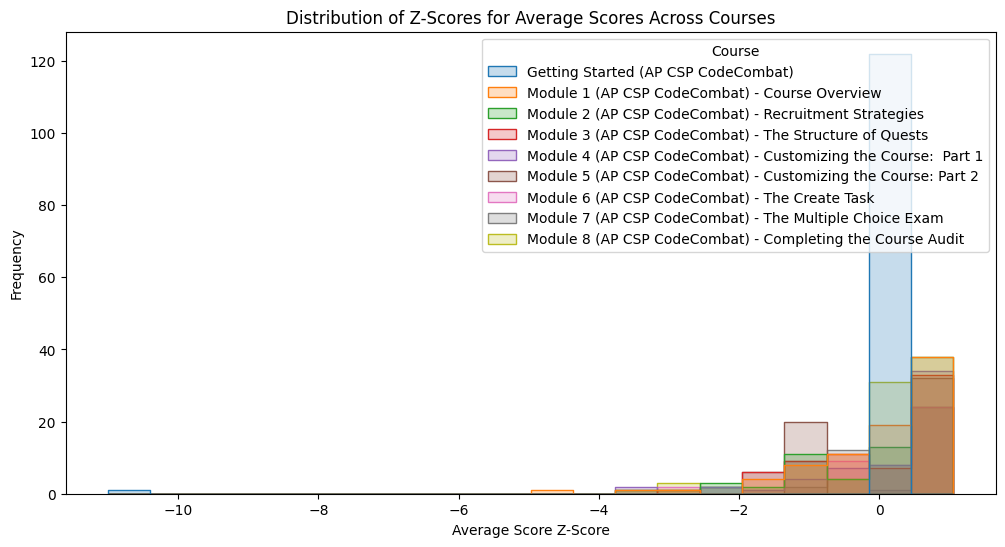

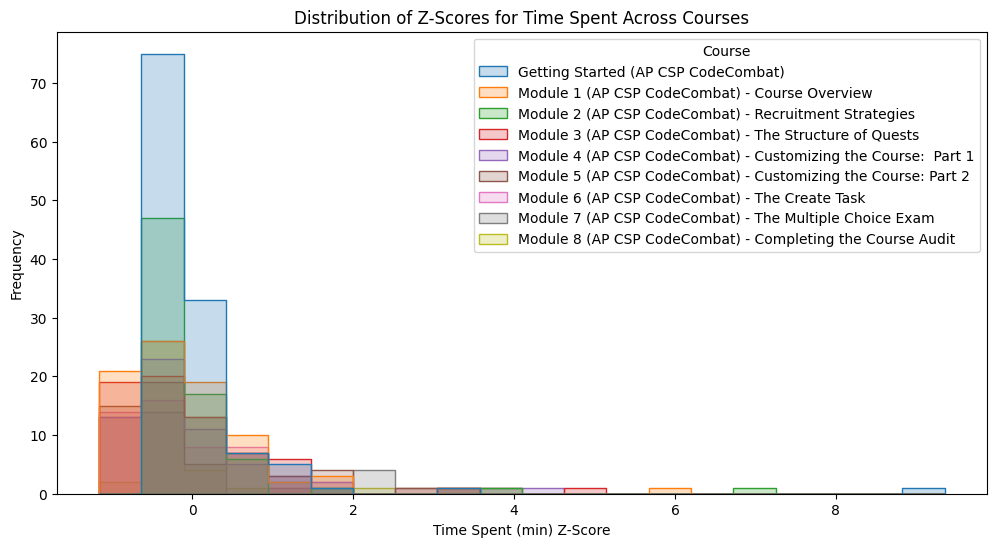

In [20]:
# Visualizing Z-score distributions for 'Average Score'
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Average Score Z-Score', hue='Course', element='step', palette='tab10', bins=20)
plt.title('Distribution of Z-Scores for Average Scores Across Courses')
plt.xlabel('Average Score Z-Score')
plt.ylabel('Frequency')
plt.show()

# Visualizing Z-score distributions for 'Time Spent (min)'
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Time Spent (min) Z-Score', hue='Course', element='step', palette='tab10', bins=20)
plt.title('Distribution of Z-Scores for Time Spent Across Courses')
plt.xlabel('Time Spent (min) Z-Score')
plt.ylabel('Frequency')
plt.show()


/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_93998/3039413122.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Course', y='Average Score Z-Score', data=df, palette='coolwarm')


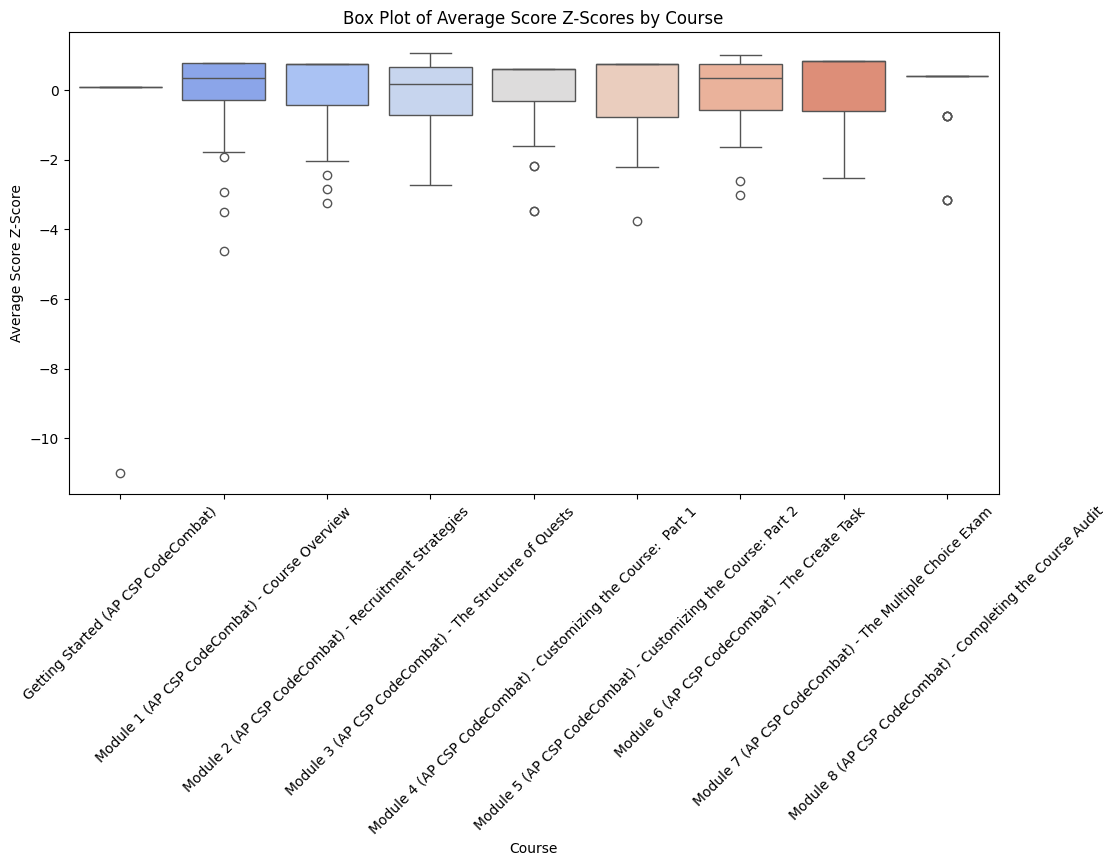

/var/folders/s7/91zjcdr93sd1ps6g_3g3fpvw0000gn/T/ipykernel_93998/3039413122.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Course', y='Time Spent (min) Z-Score', data=df, palette='coolwarm')


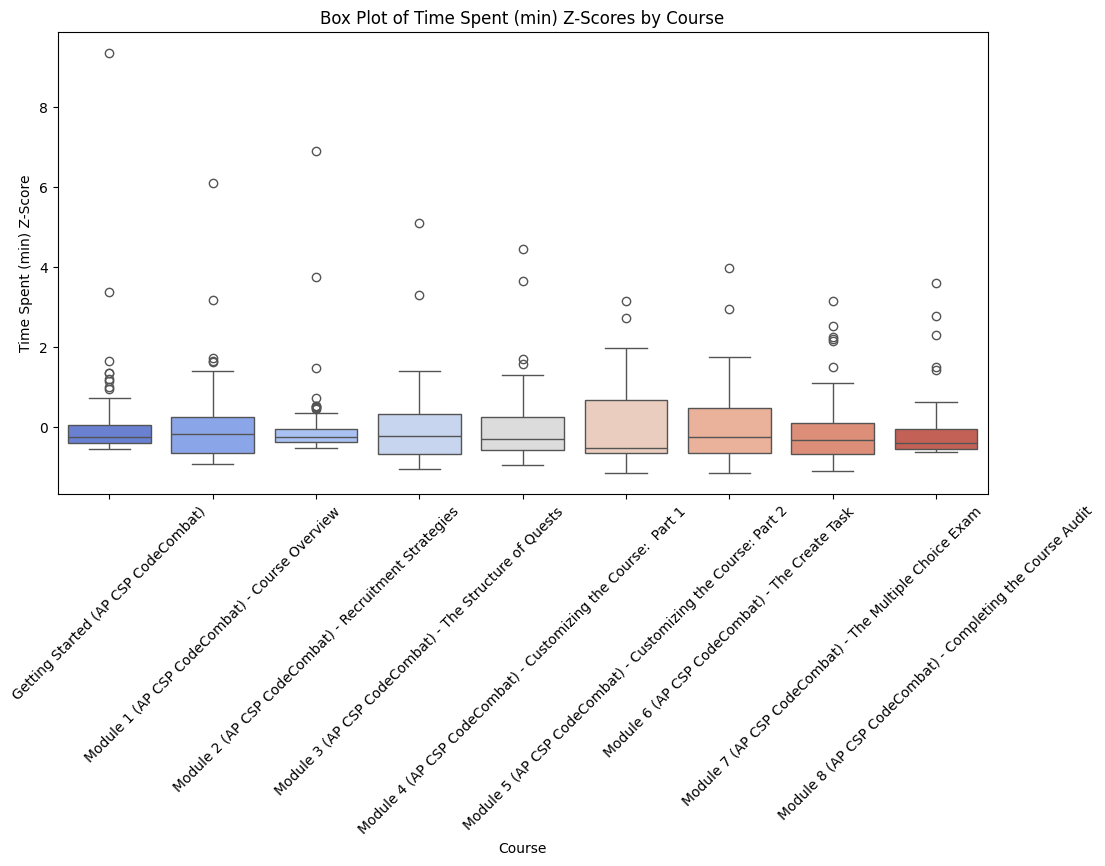

In [13]:
# Box plot for 'Average Score Z-Score'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Course', y='Average Score Z-Score', data=df, palette='coolwarm')
plt.title('Box Plot of Average Score Z-Scores by Course')
plt.xticks(rotation=45)
plt.show()

# Box plot for 'Time Spent (min) Z-Score'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Course', y='Time Spent (min) Z-Score', data=df, palette='coolwarm')
plt.title('Box Plot of Time Spent (min) Z-Scores by Course')
plt.xticks(rotation=45)
plt.show()


## 7. Pearson Correlation Coefficient

In [14]:
# Assuming 'df' is your DataFrame
grouped = df.groupby('Course')

for course, group in grouped:
    score_time_corr, p_value = pearsonr(group['Average Score'].dropna(), group['Time Spent (min)'].dropna())
    print(f"Course: {course}")
    print(f"Pearson correlation coefficient between 'Average Score' and 'Time Spent (min)': {score_time_corr:.3f}")
    print(f"P-value: {p_value:.3f}\n")


Course: Getting Started (AP CSP CodeCombat)
Pearson correlation coefficient between 'Average Score' and 'Time Spent (min)': 0.037
P-value: 0.683

Course: Module 1 (AP CSP CodeCombat) - Course Overview
Pearson correlation coefficient between 'Average Score' and 'Time Spent (min)': 0.305
P-value: 0.005

Course: Module 2 (AP CSP CodeCombat) - Recruitment Strategies
Pearson correlation coefficient between 'Average Score' and 'Time Spent (min)': 0.077
P-value: 0.516

Course: Module 3 (AP CSP CodeCombat) - The Structure of Quests
Pearson correlation coefficient between 'Average Score' and 'Time Spent (min)': 0.247
P-value: 0.044

Course: Module 4 (AP CSP CodeCombat) - Customizing the Course:  Part 1
Pearson correlation coefficient between 'Average Score' and 'Time Spent (min)': 0.215
P-value: 0.106

Course: Module 5 (AP CSP CodeCombat) - Customizing the Course: Part 2
Pearson correlation coefficient between 'Average Score' and 'Time Spent (min)': 0.291
P-value: 0.031

Course: Module 6 (AP CS